# Detección automática de enfermedades en plantas
---

Autores:
* César Augusto Villamizar Castellanos

In [6]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline
plt.style.use("ggplot")

In [7]:
# Setting initial seed
tf.random.set_seed(42)
np.random.seed(42)

## 1. Entendimiento del problema
---

Ya sea para objetivo de un sistema automatizado de cosecha o para un jardín en casa, es importante mantenerse atento a signos de debilidad o enfermedad en las plantas--ajkdlfhkjashfd

El objetivo de este proyecto es proveer un a herramienta ágil de identificación de enfermedades. Este sistema puede ser utilizado en una huerta automatizada para que, por medio de monitoreo por cámaras, se pueda realizar un seguimiento del estado de salud de las plantas y de esta manera poder tomar acciones correctivas de forma oportuna.

Los datos usados para el entrenamiento, validación y prueba de este modelo se han obtenido a través de_______. Se compone de imágenes etiquetadas de diversos tipos de hojas de plantas con específicas enfermedades o condiciones que afectan su salud


* De dónde vienen los datos?
* Qué tipo de datos tenemos?
* En qué formato están los datos?
* Cuál es el objetivo de este proyecto?
* Quienes se beneficiarían del producto?

## 2. Carga de datos
---

Implemente las funciones necesarias para cargar la información en dependencia de su procedencia (web, archivos planos, csv, bases de datos, entre otros).

In [8]:
# Loading Kaggle API in order to download dataset
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
#Download Plant desease dataset
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
! ls
! mkdir train
! unzip -qq new-plant-diseases-dataset.zip -d train

100% 2.69G/2.70G [00:20<00:00, 121MB/s]
100% 2.70G/2.70G [00:20<00:00, 142MB/s]
kaggle.json  new-plant-diseases-dataset.zip  sample_data  train
mkdir: cannot create directory ‘train’: File exists


In [10]:
path = "/content/train/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
class_dict = os.listdir(path)

In [11]:
# Limit the ammount of images per category in order to avoid RAM overload
i_per_category = 96
all_images = []
outs = []

# For each folder, get <i_per_category> images. Fill all_images and outputs
for i, val in enumerate(class_dict):
    temp_path = f"{path}{val}"
    for im_path in random.sample(os.listdir(temp_path) , i_per_category):
        all_images.append(np.array(tf.keras.preprocessing.image.load_img(temp_path + "/" + im_path,
                                                                         target_size=(224, 224, 3))))
        outs.append(i)

In [12]:
X = np.array(all_images)
y = np.array(outs)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

Y_train = tf.keras.utils.to_categorical(y_train)
Y_val = tf.keras.utils.to_categorical(y_val)

In [13]:
print(f"Image QTY: {len(X_train)}")

Image QTY: 2918


In [14]:
fig, ax = plt.subplots(5, 8, figsize=(30, 20))
for i in range(38):
  choice = random.randint(i*i_per_category,(i + 1)*i_per_category -1)
  img = all_images[choice]
  img_class = outs[choice]
  ax[i//8, i%8].imshow(img); ax[i//8, i%8].axis("off")
  #ax[i//8, i%8].set_title(img_class)
  ax[i//8, i%8].set_title(class_dict[img_class])

Output hidden; open in https://colab.research.google.com to view.

## 3. Preprocesamiento
---

Se realiza un preprocesamiento de las imágenes realizando un proceso de preprocesamiento a partir de keras, y posteriormente realizando un data augmentation.

In [15]:
def dataAugmentation(X, Y, batch_size = 32):
  # Creación de un generador de datos
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  shear_range=0.2,
                                                                  brightness_range=[0.1, 0.5],
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  fill_mode='constant')
  return train_datagen.flow(X, Y, batch_size=32)

def preprocess(X):  
  X_p = tf.keras.applications.mobilenet.preprocess_input(X)
  return X_p

In [16]:
X_train_p = preprocess(X_train)
X_val_p = preprocess(X_val)

X_train_aug = dataAugmentation(X_train_p, Y_train)
#X_train_aug = X_train_p

## 4. Modelamiento
---

Seleccione un modelo apropiado para el problema que desea solucionar (clasificación, regresión, agrupamiento, tópicos, entre otros) y entrenelo con las representaciones obtenidas en el paso anterior.


In [20]:
extractor = tf.keras.applications.MobileNet(weights='imagenet', include_top=False,
                                            input_shape=(224, 224, 3))

for layer in extractor.layers:
    layer.trainable=False

#Capa Global Average Pooling
pool = tf.keras.layers.GlobalAveragePooling2D()(extractor.output)
#Capa densa con 32 neuronas y activación Relu
dense1 = tf.keras.layers.Dense(32, activation="relu")(pool)
#Capa de dropout con una tasa de 0.2
drop1 = tf.keras.layers.Dropout(0.2)(dense1)
#Capa densa de salida para clasificación de 15 clases con softmax
dense2 = tf.keras.layers.Dense(38, activation="softmax")(drop1)

model = tf.keras.models.Model(inputs=[extractor.input], outputs=[dense2])

In [22]:
model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr=1e-3),
                 metrics=["accuracy"])

In [23]:
# Calentamiento
model.fit_generator(X_train_aug, validation_data=(X_val_p, Y_val),
                       epochs=5, steps_per_epoch=X_train.shape[0]//32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
91/91 [==============================] - 207s 2s/step - loss: 3.4148 - accuracy: 0.0994 - val_loss: 2.9474 - val_accuracy: 0.2616
Epoch 2/5
91/91 [==============================] - 179s 2s/step - loss: 2.6945 - accuracy: 0.2852 - val_loss: 2.0834 - val_accuracy: 0.4288
Epoch 3/5
91/91 [==============================] - 166s 2s/step - loss: 2.1875 - accuracy: 0.3863 - val_loss: 1.5550 - val_accuracy: 0.5575
Epoch 4/5
91/91 [==============================] - 165s 2s/step - loss: 1.8214 - accuracy: 0.4671 - val_loss: 1.2208 - val_accuracy: 0.6521
Epoch 5/5
91/91 [==============================] - 166s 2s/step - loss: 1.6322 - accuracy: 0.5198 - val_loss: 1.0286 - val_accuracy: 0.7233


In [24]:
# Liberación de últimas 10 capas
for layer in model.layers[-12:]:
    layer.trainable = True

In [25]:
# Recompilación con lr de 1e.-4
model.compile(loss="categorical_crossentropy", optimizer=tf.optimizers.Adam(lr=1e-4),
                 metrics=["accuracy"])

In [26]:
best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.h5", monitor="val_loss", 
                                                   verbose=True, save_best_only=True,
                                                   save_weights_only=True, mode="min")
hist = model.fit(x= X_train_aug, validation_data=(X_val_p, Y_val),
                                 epochs=7, steps_per_epoch=X_train.shape[0]//32,
                                 callbacks=[best_callback])

Epoch 1/7
91/91 [==============================] - ETA: 0s - loss: 1.6582 - accuracy: 0.5118
Epoch 1: val_loss improved from inf to 0.91591, saving model to checkpoint.h5
91/91 [==============================] - 211s 2s/step - loss: 1.6582 - accuracy: 0.5118 - val_loss: 0.9159 - val_accuracy: 0.7274
Epoch 2/7
91/91 [==============================] - ETA: 0s - loss: 1.3860 - accuracy: 0.5828
Epoch 2: val_loss improved from 0.91591 to 0.78203, saving model to checkpoint.h5
91/91 [==============================] - 210s 2s/step - loss: 1.3860 - accuracy: 0.5828 - val_loss: 0.7820 - val_accuracy: 0.7740
Epoch 3/7
91/91 [==============================] - ETA: 0s - loss: 1.3005 - accuracy: 0.5967
Epoch 3: val_loss did not improve from 0.78203
91/91 [==============================] - 207s 2s/step - loss: 1.3005 - accuracy: 0.5967 - val_loss: 0.8062 - val_accuracy: 0.7534
Epoch 4/7
91/91 [==============================] - ETA: 0s - loss: 1.2392 - accuracy: 0.6202
Epoch 4: val_loss improved from

## 6. Evaluacion
---

Evalúe el desempeño de su modelo con una métrica de desempeño apropiada al problema.


23/23 [==============================] - 30s 1s/step
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.61      0.95      0.74        21
           2       0.86      0.22      0.35        27
           3       0.50      0.05      0.08        22
           4       0.91      0.84      0.87        25
           5       0.91      0.45      0.61        22
           6       0.20      0.36      0.26        14
           7       0.69      1.00      0.82        18
           8       0.72      0.59      0.65        22
           9       0.79      0.90      0.84        21
          10       0.90      0.75      0.82        24
          11       1.00      0.33      0.50        21
          12       0.79      0.88      0.83        17
          13       0.73      0.65      0.69        17
          14       0.70      0.47      0.56        15
          15       0.90      0.50      0.64        18
          16       0.72     

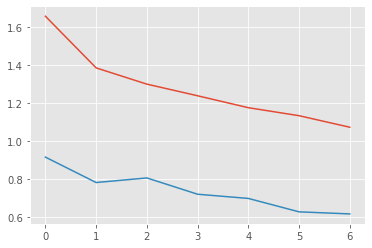

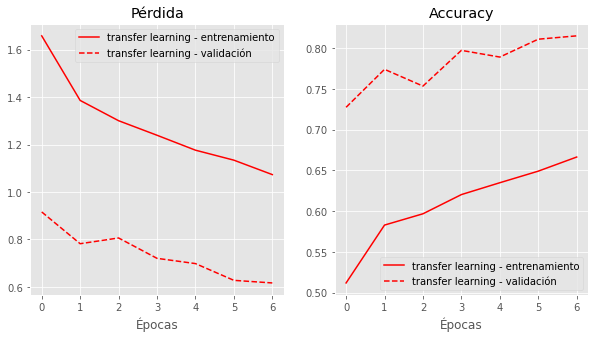

In [27]:
def evaluate():
  plt.plot(hist.history["loss"])
  plt.plot(hist.history["val_loss"])
  model.load_weights("transfer_learning.h5")
  print(classification_report(y_val, 
                            np.argmax(model.predict(X_val_p,
                                                       batch_size=32),
                                      axis=1)))
  plt.figure(figsize=(10,5))
  plt.subplot(121)
  plt.plot(hist.history["loss"], "r", label="transfer learning - entrenamiento")
  plt.plot(hist.history["val_loss"], "r--", label="transfer learning - validación")
  plt.xlabel("Épocas")
  plt.title("Pérdida")
  plt.legend()
  plt.subplot(122)
  plt.plot(hist.history["accuracy"], "r", label="transfer learning - entrenamiento")
  plt.plot(hist.history["val_accuracy"], "r--", label="transfer learning - validación")
  plt.xlabel("Épocas")
  plt.title("Accuracy")
  plt.legend()
  
evaluate()

## 7. Discusión y Conclusiones
---

Interprete los resultados obtenidos y escriba una discusión de los resultados.
